In [1]:
#import libraries
import pandas as pd
import numpy as np

In [2]:
#read in the csv files
cities = pd.read_csv('cities.csv')
mt = pd.read_csv('meal_types.csv')
meals = pd.read_csv('meals.csv')
mmt = pd.read_csv('monthly_member_totals.csv')
rt = pd.read_csv('restaurant_types.csv')
rests = pd.read_csv('restaurants.csv')
st = pd.read_csv('serve_types.csv')

In [3]:
#merging files together
first_merge = pd.merge(meals, st, on='serve_type_id', how='left')
second_merge = pd.merge(first_merge, mt, on='meal_type_id', how='left')
third_merge = pd.merge(second_merge, rests, on='restaurant_id', how='left')
fourth_merge = pd.merge(third_merge, rt, on='restaurant_type_id', how='left')
df = pd.merge(fourth_merge, cities, on='city_id', how='left')
columns_to_drop = [col for col in df.columns if 'id' in col]
df = df.drop(columns=columns_to_drop)
df.columns

Index(['hot_cold', 'meal_name', 'price', 'serve_type', 'meal_type',
       'restaurant_name', 'income_persentage', 'restaurant_type', 'city'],
      dtype='object')

In [4]:
#missing values per columns
print(mmt.isnull().sum())
print(mmt.shape)

member_id          0
first_name         0
surname            0
sex                0
email              0
city               0
year               0
month              0
order_count       14
meals_count       16
monthly_budget    22
total_expense      0
balance            0
commission         0
dtype: int64
(1200, 14)


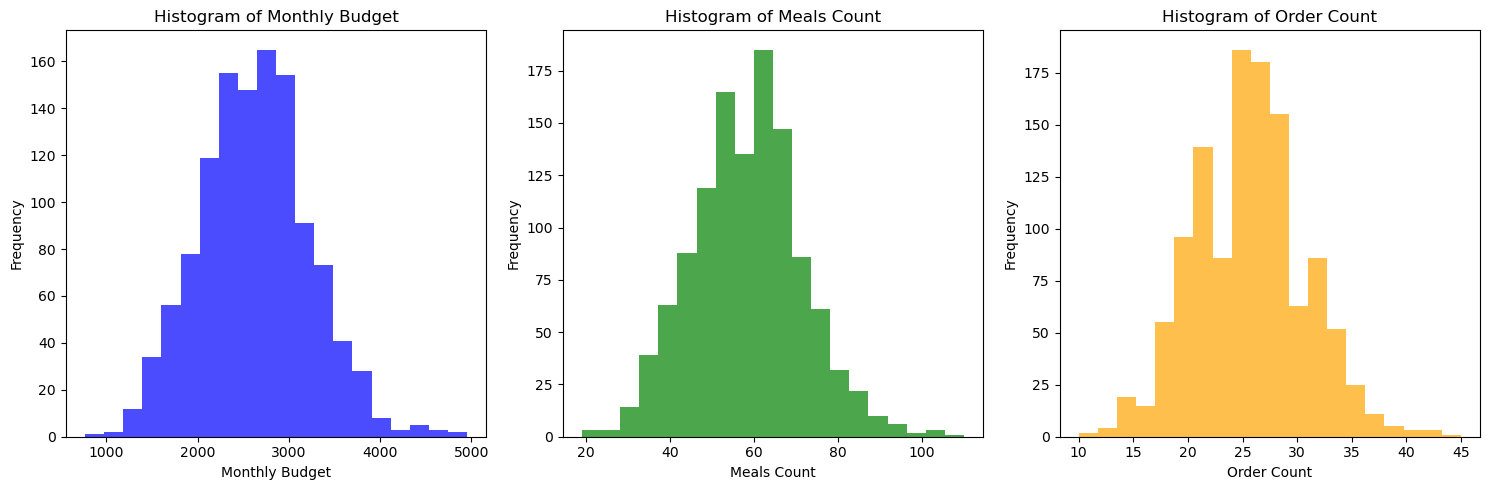

In [5]:
#There are 3 columns with null values. They are order_count: 14, meals_count: 16, monthly_budget: 22. Although they are not many, and consist less than 3% of the data, I am gonna impute them as I don't want to lose
#any data. So to decide between mean or median imputation, I am gonna check out their distribution.
import matplotlib.pyplot as plt

# Plotting histograms for monthly_budget, meals_count and order_count variables
plt.figure(figsize=(15, 5))

# Histogram for monthly_budget
plt.subplot(1, 3, 1)
plt.hist(mmt['monthly_budget'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Monthly Budget')
plt.xlabel('Monthly Budget')
plt.ylabel('Frequency')

# Histogram for meals_count
plt.subplot(1, 3, 2)
plt.hist(mmt['meals_count'], bins=20, color='green', alpha=0.7)
plt.title('Histogram of Meals Count')
plt.xlabel('Meals Count')
plt.ylabel('Frequency')

# Histogram for order_count
plt.subplot(1, 3, 3)
plt.hist(mmt['order_count'], bins=20, color='orange', alpha=0.7)
plt.title('Histogram of Order Count')
plt.xlabel('Order Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [6]:
#checking central tendency of columns with null values for further insights
mean_with_missing_values = mmt[['monthly_budget', 'meals_count', 'order_count', 'commission', 'balance', 'total_expense']].mean()
mean_with_missing_values

monthly_budget    2632.599660
meals_count         58.451858
order_count         25.514334
commission         201.461506
balance          -1919.091392
total_expense      706.500000
dtype: float64

In [7]:
#The three variables appear to have normal distribution according to above histograms, so I am gonna impute them using mean imputation method.
mmt['monthly_budget'].fillna(mmt['monthly_budget'].mean(), inplace=True)
mmt['meals_count'].fillna(mmt['meals_count'].mean(), inplace=True)
mmt['order_count'].fillna(mmt['order_count'].mean(), inplace=True)

# Let's see if there's any missing value left
print(mmt.isnull().sum())
#done

member_id         0
first_name        0
surname           0
sex               0
email             0
city              0
year              0
month             0
order_count       0
meals_count       0
monthly_budget    0
total_expense     0
balance           0
commission        0
dtype: int64


In [8]:
#It is obvious that the central tendeny, in other word, mean didn't change after imputing the missing values. It is a good sign actually, as it shows
#that using mean imputation was the correct way of handling missing values since it did not introduce any bias into the data.
mean_after = mmt[['monthly_budget', 'meals_count', 'order_count', 'commission', 'balance', 'total_expense']].mean()
print(mean_after)
print(' ')
print(mean_with_missing_values)

monthly_budget    2632.599660
meals_count         58.451858
order_count         25.514334
commission         201.461506
balance          -1919.091392
total_expense      706.500000
dtype: float64
 
monthly_budget    2632.599660
meals_count         58.451858
order_count         25.514334
commission         201.461506
balance          -1919.091392
total_expense      706.500000
dtype: float64


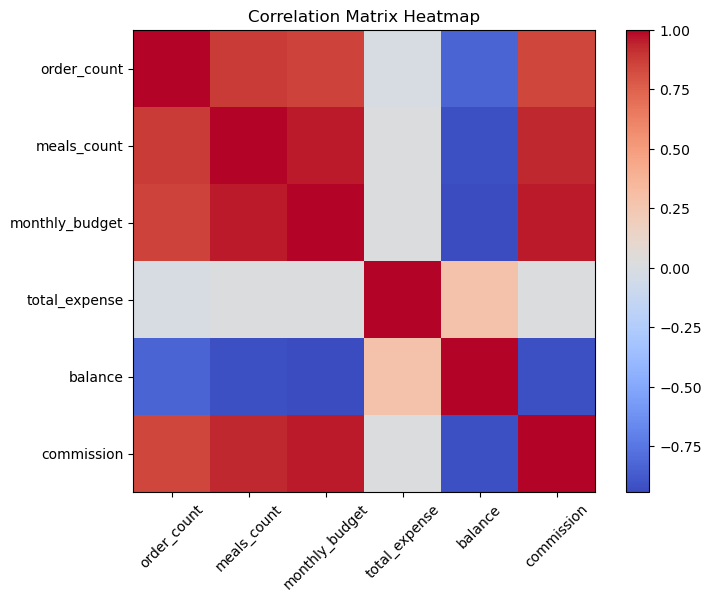

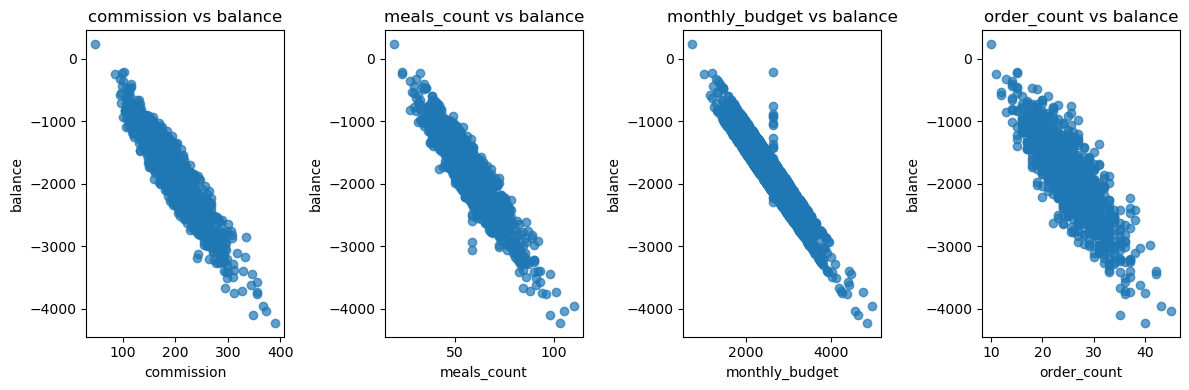

In [9]:
#I am going to apply Pearson's correlation and develop scatter plots to explore the potential linear relationships between pair of numerical variables.
# First we need to select only numerical columns for correlation calculation
numerical_columns = ['order_count', 'meals_count', 'monthly_budget', 'total_expense', 'balance', 'commission']
mmt_numerical = mmt[numerical_columns]

# Now, let's coompute correlation matrix
correlation_matrix = mmt_numerical.corr()

# Plotting correlation matrix heatmap
plt.figure(figsize=(8, 6))
plt.title('Correlation Matrix Heatmap')
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

# Plotting scatter plots for pairs with negative correlation
plt.figure(figsize=(12, 4))

# I chose these pairs to analyze based on potential negative correlation
pairs_to_analyze = [('commission', 'balance'), ('meals_count', 'balance'), ('monthly_budget', 'balance'), ('order_count', 'balance')]

for i, (var1, var2) in enumerate(pairs_to_analyze):
    plt.subplot(1, len(pairs_to_analyze), i + 1)
    plt.scatter(mmt[var1], mmt[var2], alpha=0.7)
    plt.title(f'{var1} vs {var2}')
    plt.xlabel(var1)
    plt.ylabel(var2)

plt.tight_layout()
plt.show()

#According to the Pearson's correlation matrix and scatter plots below, we can confidently conclude that there's a strong negative linear correlation
#between balance & commission, balance & monthly_budget, balance & meals_count pairs. There is negative linear correlation between balance & order_count
#too.


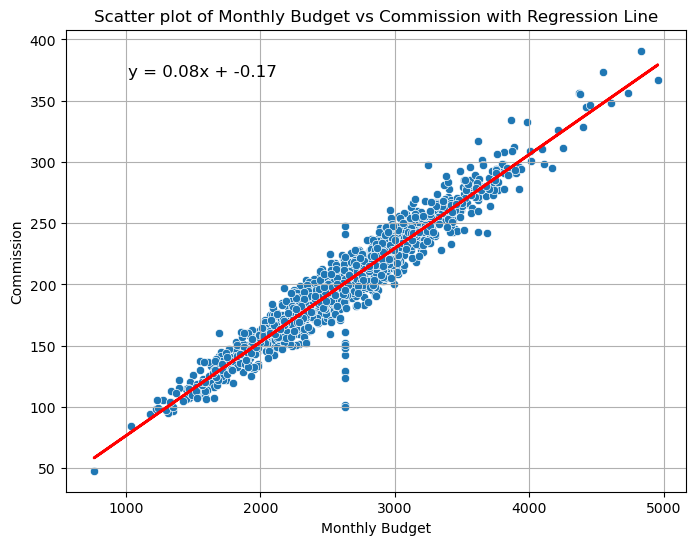

Equation of the regression line: y = 0.08x + -0.17
Pearson correlation coefficient: 0.9611945074444678


In [10]:
#Earlier when I explored correlation betwen pairs, I noticed that there's a strong positive correlation between monthly_budget & commission pair.
#So, I am gonna make a scatter plot of that pair with the fitted regression line and equation of the line.
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Scatter plot with regression line for commission vs monthly_budget
plt.figure(figsize=(8, 6))
sns.scatterplot(x='monthly_budget', y='commission', data=mmt)
plt.title('Scatter plot of Monthly Budget vs Commission with Regression Line')

# Let's fit and plot regression line
model = LinearRegression()
X = mmt['monthly_budget'].values.reshape(-1, 1)
y = mmt['commission'].values.reshape(-1, 1)
model.fit(X, y)
plt.plot(X, model.predict(X), color='red', linewidth=2)

# Equation of the regression line
slope = model.coef_[0][0]
intercept = model.intercept_[0]
equation = f'y = {slope:.2f}x + {intercept:.2f}'
plt.text(0.1, 0.9, equation, fontsize=12, transform=plt.gca().transAxes)

plt.xlabel('Monthly Budget')
plt.ylabel('Commission')
plt.grid(True)
plt.show()

print(f"Equation of the regression line: {equation}")
print(f"Pearson correlation coefficient: {mmt['monthly_budget'].corr(mmt['commission'])}")


In [11]:
#The equation of the regression line y = 0.08x - 0.17 has a slope of 0.08, meaning that for each unit increase in monthly_budget, the commission is
#expected to go up by 0.08. The line has an intercept of -0.17 representng commission when monthly_budget is 0.

In [13]:
from scipy.stats import chi2_contingency

# I am gonna go ahead and select hot_cold and meal_type categorical variables for chi-square test.
cat_var1 = 'hot_cold'
cat_var2 = 'serve_type'

# Let's create contingency table
contingency_table = pd.crosstab(df[cat_var1], df[cat_var2])
print("Contingency Table:")
print(contingency_table)
print()

# Time to apply chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)
print()

# Interpretion of the test outcome
print(f"Significance Level (alpha): .05")
if p < .05:
    print("Reject the null hypothesis. There is sufficient evidence to conclude that there is an association between meal serve type and temperature of food being served", 
          f"{cat_var1} and {cat_var2}.")
else:
    print("Fail to reject the null hypothesis. There is not enough evidence to conclude that there is an association between meal serve type and temperature of food being served", 
          f"between {cat_var1} and {cat_var2}.")
#P-value is way above 0.05 which mean we accept the alternative hypothesis which states that there is not enough evidence between these two variables.

Contingency Table:
serve_type  Desert  Main  Starter
hot_cold                         
Cold            66    60       53
Hot             67    54       50

Chi-Square Statistic: 0.22794886024568203
P-value: 0.8922807711004243
Degrees of Freedom: 2
Expected Frequencies:
[[68.02       58.30285714 52.67714286]
 [64.98       55.69714286 50.32285714]]

Significance Level (alpha): .05
Fail to reject the null hypothesis. There is not enough evidence to conclude that there is an association between meal serve type and temperature of food being served between hot_cold and serve_type.


In [14]:
from scipy import stats

# To conduct one sample T-test, I am gonna use order_count from mmt dataset and make an assumption that population mean is 20.
var = 'order_count'
p_m = 20 #population mean

# Let's perform one-sample t-test
t_statistic, p_value = stats.ttest_1samp(mmt[var], p_m)

# Printing the results of t-test
print(f"One-Sample T-Test for {var} against population mean {p_m}:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpreting test outcome
print(f"\nSignificance Level (alpha): .05")
if p_value < .05:
    print(f"Reject the null hypothesis. There is sufficient evidence to conclude that the mean {var} is different from {p_m}.")
else:
    print(f"Fail to reject the null hypothesis. There is not enough evidence to conclude that the mean {variable} is different from {p_m}.")

One-Sample T-Test for order_count against population mean 20:
T-statistic: 37.9487571491097
P-value: 1.2083274942214064e-207

Significance Level (alpha): .05
Reject the null hypothesis. There is sufficient evidence to conclude that the mean order_count is different from 20.


In [15]:
# For two-sample t-test I am gonna go ahead and select order_count and meals_count variables.
var1 = 'order_count'
var2 = 'meals_count'

# Performing two-sample t-test
t_statistic, p_value = stats.ttest_ind(mmt[var1], mmt[var2])

# Print the results of the above test
print(f"Two-Sample T-Test between {var1} and {var2}:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpreting test outcome
print(f"\nSignificance Level (alpha): .05")
if p_value < .05:
    print(f"Reject the null hypothesis. There is sufficient evidence to conclude that the means of {var1} and {var2} are different.")
else:
    print(f"Fail to reject the null hypothesis. There is not enough evidence to conclude that the means of {var1} and {var2} are different.")


Two-Sample T-Test between order_count and meals_count:
T-statistic: -82.04400778976157
P-value: 0.0

Significance Level (alpha): .05
Reject the null hypothesis. There is sufficient evidence to conclude that the means of order_count and meals_count are different.


In [16]:
#For the second pair I am gonna go with monthly_budget and total_expense variables
var1 = 'monthly_budget'
var2 = 'total_expense'

# Performing two-sample t-test
t_statistic, p_value = stats.ttest_ind(mmt[var1], mmt[var2])

# The results
print(f"Two-Sample T-Test between {var1} and {var2}:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation
print(f"\nSignificance Level (alpha): .05")
if p_value < .05:
    print(f"Reject the null hypothesis. There is sufficient evidence to conclude that the means of {var1} and {var2} are different.")
else:
    print(f"Fail to reject the null hypothesis. There is not enough evidence to conclude that the means of {var1} and {var2} are different.")


Two-Sample T-Test between monthly_budget and total_expense:
T-statistic: 106.62856462601741
P-value: 0.0

Significance Level (alpha): .05
Reject the null hypothesis. There is sufficient evidence to conclude that the means of monthly_budget and total_expense are different.
